In [13]:
# Customized def 
# import models 

import os
from glob import glob 
import cv2 
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import layers
import random

In [24]:
base_path = 'C:/Users/user/Desktop/isic_images'
base_models_path = 'C:/Users/user/Desktop/models/isic_images'

N_RES = 32

learning_rate = 0.001
batch_size = 32
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05
input_shape = (N_RES, N_RES, 3)
num_classes = 3

labels_idx = {
    'benign' : 0 , 
    'indeterminate' : 1,
    'malignant' : 2,
}

In [15]:
def create_encoder(input_shape, data_augmentation):
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
def create_classifier(encoder, input_shape, learning_rate, dropout_rate, hidden_units, num_classes, trainable=True):
    
    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

In [17]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

In [18]:
def add_projection_head(encoder, input_shape, projection_units):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="cifar-encoder_with_projection-head"
    )
    return model

In [19]:
images_dataset = glob(os.path.join(base_path, '*.JPG'))
labels_dataset = pd.read_csv(os.path.join(base_path, 'metadata.csv')).dropna(subset=['benign_malignant'])


images = [] 
labels = [] 
for data in images_dataset:
    img = cv2.imread(data, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_RES, N_RES))
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    
    # idx = labels_dataset[labels_dataset[]]
    filename = data.split('\\')[-1][:-4]
    lbl = labels_dataset[labels_dataset['isic_id'] == filename]['benign_malignant']
    lbl = str(lbl.values[0])
    
    # lbl = lbl.to_string()
    
    
    images.append(img) 
    labels.append(tf.keras.utils.to_categorical(labels_idx[lbl], num_classes))
    
# for idx, val in labels_dataset.iterrows():
    # print(val)
    # labels.append(val['melanocytic'])
    # print(val['benign_malignant'])
    # if val['benign_malignant'] is None:
    #     pass
    
    # if val['melanocytic'] is NaN:
    # idx = labels_idx[val['benign_malignant']]
    # lbl = tf.keras.utils.to_categorical(idx, num_classes)
    # labels.append(lbl) 


random.shuffle(images)
random.shuffle(labels)

images = np.reshape(images, [-1, N_RES, N_RES, 3])
labels = np.reshape(labels, [-1, num_classes])

In [20]:
    
test_rate = int(len(images) * 0.3)
x_test = images[:test_rate]
x_train = images[test_rate:]

y_test = labels[:test_rate]
y_train = labels[test_rate:]

print(x_train.shape)
print(y_train.shape)

(700, 32, 32, 3)
(700, 3)


In [21]:
data_augmentation = keras.Sequential([
            layers.Normalization(),
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.02),
            layers.RandomWidth(0.2),
            layers.RandomHeight(0.2),
        ])

data_augmentation.layers[0].adapt(x_train)

In [22]:
encoder = create_encoder(input_shape, data_augmentation)

classifier = create_classifier(encoder, input_shape, learning_rate, dropout_rate, hidden_units, num_classes)


# 
encoder = create_encoder(input_shape, data_augmentation)

encoder_with_projection_head = add_projection_head(encoder, input_shape, projection_units)

encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

In [23]:

history = encoder_with_projection_head.fit(
    x=x_train, 
    y=y_train, 
    batch_size=batch_size, 
    epochs=num_epochs
)


Epoch 1/50


InvalidArgumentError: Graph execution error:

logits and labels must be broadcastable: logits_size=[32,32] labels_size=[96,32]
	 [[{{node softmax_cross_entropy_with_logits_1}}]] [Op:__inference_train_function_39381]

In [ ]:

classifier = models.create_classifier(encoder, trainable=False)

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

In [ ]:

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")


In [25]:
df = pd.read_csv(os.path.join(base_models_path, '20220624-152038_isic_classification.csv'))
df 

,Unnamed: 0,loss,sparse_categorical_accuracy
0,0,3.483170,0.692857
1,1,1.235821,0.744286
2,2,0.919390,0.794286
3,3,0.758151,0.797143
4,4,0.692417,0.808571
5,5,0.656134,0.814286
6,6,0.656514,0.812857
7,7,0.651814,0.811429
8,8,0.653117,0.814286
9,9,0.663779,0.814286


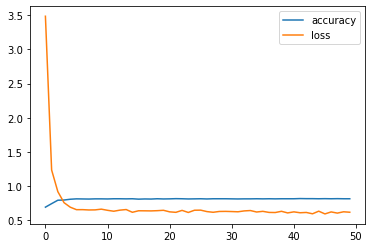

In [29]:
import matplotlib.pyplot as plt 

plt.plot(df['sparse_categorical_accuracy'], label='accuracy')
plt.plot(df['loss'], label='loss')
plt.legend()
plt.show()